In [1]:
#Import the required packages
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
pip install --user tensorflow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
#load the dataset
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [4]:
#visualize the data
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [5]:
#dispaly the sample of citation
citations.sample(frac=1).head()

,target,source
2390,23069,74700
5000,574264,576795
4649,238099,1127851
4284,149139,1123215
3150,45533,1116974


In [6]:
#load the papers data into a Pandas DataFrame
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [7]:
print(papers.sample(5).T)

                            2590             2454        1805           1445  \
paper_id                  431206           627024      126868         136768   
term_0                         0                0           0              0   
term_1                         0                0           0              0   
term_2                         0                0           0              0   
term_3                         0                0           0              0   
...                          ...              ...         ...            ...   
term_1429                      0                0           0              0   
term_1430                      0                0           0              0   
term_1431                      0                0           0              0   
term_1432                      0                0           0              0   
subject    Probabilistic_Methods  Neural_Networks  Case_Based  Rule_Learning   

                         1638  
paper_i

In [8]:
#display the count of the papers in each subject.
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [9]:
#convert the paper ids and the subjects into zero-based indices
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

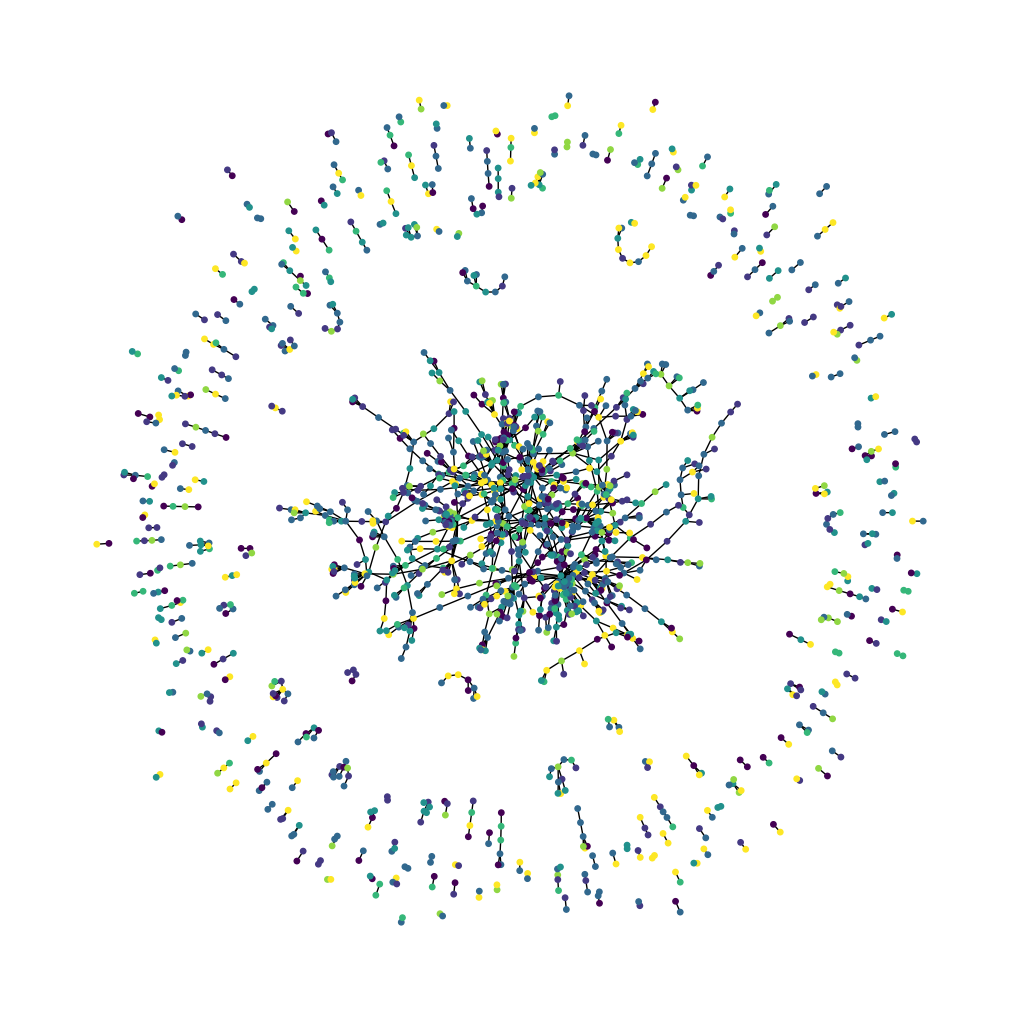

In [10]:
# visualize the citation graph
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

Split the dataset into stratified train and test sets

In [11]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1348, 1435)
Test data shape: (1360, 1435)


In [12]:
#Implement Train and Evaluate Experiment
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [13]:
#compiling and training an input model using the given training data by creating a function
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [14]:
#displays the loss and accuracy curves of the model during training using a function
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

Implementing Feedforward Network (FFN) Module,
We will use this module in the baseline and the GNN models

In [15]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

# Build a Baseline Neural Network Model

In [16]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

C:\Users\gargi\AppData\Local\Temp\ipykernel_2304\3641831727.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[feature_names].to_numpy()
C:\Users\gargi\AppData\Local\Temp\ipykernel_2304\3641831727.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[feature_names].to_numpy()


# Implement a baseline classifier

In [17]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

# Train the baseline classifier

In [18]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 6s 138ms/step - loss: 3.9332 - acc: 0.1485 - val_loss: 1.8555 - val_acc: 0.2857
Epoch 2/300
5/5 [==============================] - 0s 29ms/step - loss: 2.6917 - acc: 0.2594 - val_loss: 1.8480 - val_acc: 0.3103
Epoch 3/300
5/5 [==============================] - 0s 28ms/step - loss: 2.2959 - acc: 0.2795 - val_loss: 1.8524 - val_acc: 0.3498
Epoch 4/300
5/5 [==============================] - 0s 29ms/step - loss: 2.1973 - acc: 0.2585 - val_loss: 1.8453 - val_acc: 0.4729
Epoch 5/300
5/5 [==============================] - 0s 29ms/step - loss: 1.9752 - acc: 0.2961 - val_loss: 1.8379 - val_acc: 0.3842
Epoch 6/300
5/5 [==============================] - 0s 27ms/step - loss: 1.8734 - acc: 0.3354 - val_loss: 1.8122 - val_acc: 0.3596
Epoch 7/300
5/5 [==============================] - 0s 27ms/step - loss: 1.7616 - acc: 0.3616 - val_loss: 1.7743 - val_acc: 0.3941
Epoch 8/300
5/5 [==============================] - 0s 28ms/step - loss: 1.6849 - acc: 0.3

5/5 [==============================] - 0s 25ms/step - loss: 0.4372 - acc: 0.8419 - val_loss: 0.6905 - val_acc: 0.7833
Epoch 64/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4398 - acc: 0.8611 - val_loss: 0.7213 - val_acc: 0.7635
Epoch 65/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4467 - acc: 0.8559 - val_loss: 0.7502 - val_acc: 0.7438
Epoch 66/300
5/5 [==============================] - 0s 24ms/step - loss: 0.4862 - acc: 0.8314 - val_loss: 0.7856 - val_acc: 0.7438
Epoch 67/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4348 - acc: 0.8550 - val_loss: 0.7381 - val_acc: 0.7586
Epoch 68/300
5/5 [==============================] - 0s 24ms/step - loss: 0.4020 - acc: 0.8655 - val_loss: 0.7302 - val_acc: 0.7488
Epoch 69/300
5/5 [==============================] - 0s 24ms/step - loss: 0.4684 - acc: 0.8367 - val_loss: 0.7570 - val_acc: 0.7586
Epoch 70/300
5/5 [==============================] - 0s 24ms/step - loss: 0.4092 - acc: 0.8603 - 

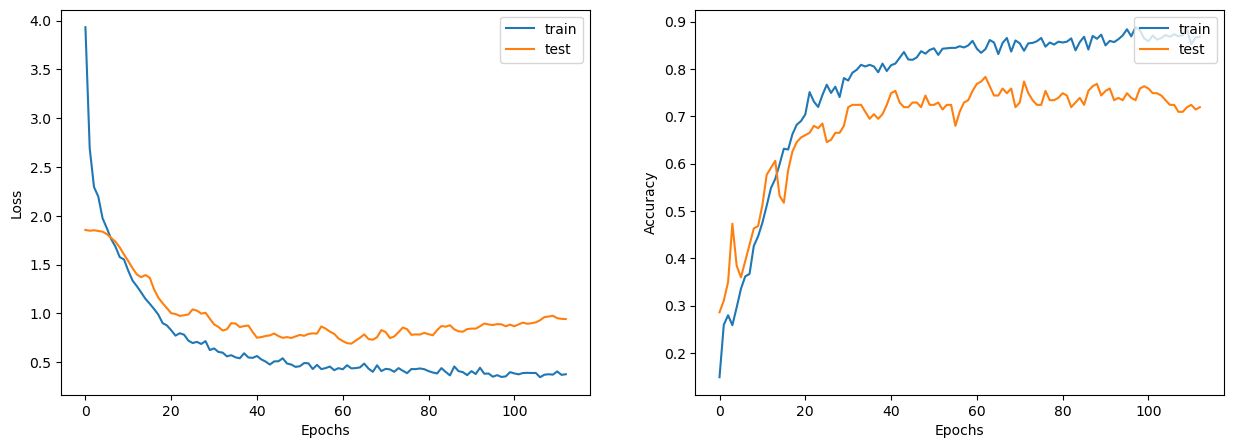

In [19]:
#plotting the learning curves
display_learning_curves(history)

In [20]:
#evaluate the baseline model on the test data split
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 75.66%


In [21]:
#Examine the baseline model predictions by creating new data instances by randomly generating binary word vectors with respect to the word presence probabilities.
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [22]:
#showing the baseline model predictions given these randomly generated instances
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 393ms/step
Instance 1:
- Case_Based: 5.5%
- Genetic_Algorithms: 1.47%
- Neural_Networks: 19.41%
- Probabilistic_Methods: 1.9%
- Reinforcement_Learning: 1.35%
- Rule_Learning: 48.26%
- Theory: 22.09%
Instance 2:
- Case_Based: 2.73%
- Genetic_Algorithms: 83.31%
- Neural_Networks: 8.14%
- Probabilistic_Methods: 0.85%
- Reinforcement_Learning: 2.28%
- Rule_Learning: 1.1%
- Theory: 1.59%
Instance 3:
- Case_Based: 1.59%
- Genetic_Algorithms: 0.78%
- Neural_Networks: 41.73%
- Probabilistic_Methods: 8.14%
- Reinforcement_Learning: 2.93%
- Rule_Learning: 0.63%
- Theory: 44.2%
Instance 4:
- Case_Based: 9.76%
- Genetic_Algorithms: 4.16%
- Neural_Networks: 60.42%
- Probabilistic_Methods: 4.61%
- Reinforcement_Learning: 2.14%
- Rule_Learning: 2.16%
- Theory: 16.75%
Instance 5:
- Case_Based: 0.64%
- Genetic_Algorithms: 0.34%
- Neural_Networks: 94.35%
- Probabilistic_Methods: 1.63%
- Reinforcement_Learning: 0.54%
- Rule_Learning: 1.16%
- Theory: 1.34%
Instanc

# Build a Graph Neural Network Model

In [23]:
##Prepare the data for the graph mode
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


C:\Users\gargi\AppData\Local\Temp\ipykernel_2304\2771548705.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32


In [24]:
#Implement a graph convolution layer
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

# Implement a graph neural network node classifier

In [25]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [26]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.12731235  0.04219296  0.01700336 -0.06123239 -0.00489985 -0.04303075
   0.08268807]
 [-0.07590755 -0.04704773  0.21737474 -0.11024459  0.08033321  0.08012372
  -0.06566958]
 [-0.06250867  0.06689809 -0.10097301 -0.02316352  0.01682834  0.12050769
   0.11157987]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                            

In [27]:
#Train the GNN model
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 7s 249ms/step - loss: 2.2970 - acc: 0.1913 - val_loss: 1.9480 - val_acc: 0.1084
Epoch 2/300
5/5 [==============================] - 1s 125ms/step - loss: 2.0097 - acc: 0.2498 - val_loss: 1.9343 - val_acc: 0.1034
Epoch 3/300
5/5 [==============================] - 1s 127ms/step - loss: 1.9436 - acc: 0.2550 - val_loss: 1.9261 - val_acc: 0.1823
Epoch 4/300
5/5 [==============================] - 1s 128ms/step - loss: 1.8983 - acc: 0.2681 - val_loss: 1.9224 - val_acc: 0.2167
Epoch 5/300
5/5 [==============================] - 1s 125ms/step - loss: 1.8643 - acc: 0.2900 - val_loss: 1.9163 - val_acc: 0.2660
Epoch 6/300
5/5 [==============================] - 1s 131ms/step - loss: 1.8636 - acc: 0.2952 - val_loss: 1.9084 - val_acc: 0.2857
Epoch 7/300
5/5 [==============================] - 1s 125ms/step - loss: 1.8530 - acc: 0.3022 - val_loss: 1.9002 - val_acc: 0.2857
Epoch 8/300
5/5 [==============================] - 1s 116ms/step - loss: 1.8336 - a

5/5 [==============================] - 1s 127ms/step - loss: 0.6111 - acc: 0.7834 - val_loss: 0.7319 - val_acc: 0.7340
Epoch 64/300
5/5 [==============================] - 1s 126ms/step - loss: 0.5608 - acc: 0.8218 - val_loss: 0.7699 - val_acc: 0.7291
Epoch 65/300
5/5 [==============================] - 1s 124ms/step - loss: 0.6472 - acc: 0.7825 - val_loss: 0.8167 - val_acc: 0.7044
Epoch 66/300
5/5 [==============================] - 1s 125ms/step - loss: 0.6291 - acc: 0.7913 - val_loss: 0.7451 - val_acc: 0.7241
Epoch 67/300
5/5 [==============================] - 1s 130ms/step - loss: 0.6054 - acc: 0.7983 - val_loss: 0.7488 - val_acc: 0.6995
Epoch 68/300
5/5 [==============================] - 1s 129ms/step - loss: 0.6022 - acc: 0.7965 - val_loss: 0.7808 - val_acc: 0.7094
Epoch 69/300
5/5 [==============================] - 1s 115ms/step - loss: 0.5962 - acc: 0.8105 - val_loss: 0.7741 - val_acc: 0.7340
Epoch 70/300
5/5 [==============================] - 1s 119ms/step - loss: 0.5845 - acc: 0

Epoch 125/300
5/5 [==============================] - 1s 111ms/step - loss: 0.4653 - acc: 0.8428 - val_loss: 0.7406 - val_acc: 0.7833
Epoch 126/300
5/5 [==============================] - 1s 113ms/step - loss: 0.4099 - acc: 0.8533 - val_loss: 0.7554 - val_acc: 0.7685
Epoch 127/300
5/5 [==============================] - 1s 109ms/step - loss: 0.4191 - acc: 0.8707 - val_loss: 0.7579 - val_acc: 0.7685
Epoch 128/300
5/5 [==============================] - 1s 114ms/step - loss: 0.4132 - acc: 0.8638 - val_loss: 0.7444 - val_acc: 0.7882
Epoch 129/300
5/5 [==============================] - 1s 109ms/step - loss: 0.4378 - acc: 0.8533 - val_loss: 0.7593 - val_acc: 0.7980
Epoch 130/300
5/5 [==============================] - 1s 114ms/step - loss: 0.4382 - acc: 0.8524 - val_loss: 0.7114 - val_acc: 0.8030
Epoch 131/300
5/5 [==============================] - 1s 117ms/step - loss: 0.3886 - acc: 0.8838 - val_loss: 0.7012 - val_acc: 0.7931
Epoch 132/300
5/5 [==============================] - 1s 117ms/step - 

5/5 [==============================] - 1s 109ms/step - loss: 0.3167 - acc: 0.9013 - val_loss: 0.8202 - val_acc: 0.7931
Epoch 187/300
5/5 [==============================] - 1s 111ms/step - loss: 0.3309 - acc: 0.8926 - val_loss: 0.8178 - val_acc: 0.7882
Epoch 188/300
5/5 [==============================] - 1s 111ms/step - loss: 0.2854 - acc: 0.9092 - val_loss: 0.8091 - val_acc: 0.7980
Epoch 189/300
5/5 [==============================] - 1s 109ms/step - loss: 0.3476 - acc: 0.8900 - val_loss: 0.7961 - val_acc: 0.7882
Epoch 190/300
5/5 [==============================] - 1s 111ms/step - loss: 0.3577 - acc: 0.8856 - val_loss: 0.8240 - val_acc: 0.8079
Epoch 191/300
5/5 [==============================] - 1s 112ms/step - loss: 0.3577 - acc: 0.8882 - val_loss: 0.8168 - val_acc: 0.8030
Epoch 192/300
5/5 [==============================] - 1s 122ms/step - loss: 0.3405 - acc: 0.8934 - val_loss: 0.7744 - val_acc: 0.8128
Epoch 193/300
5/5 [==============================] - 1s 126ms/step - loss: 0.3408 -

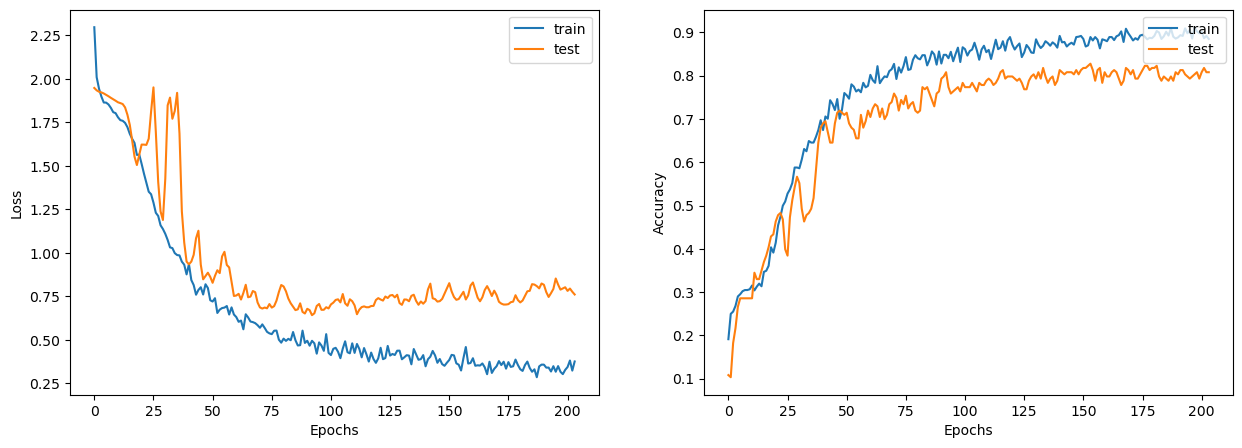

In [28]:
#plotting the learning curves
display_learning_curves(history)

In [29]:
#evaluate the GNN model on the test data split
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 81.03%


In [30]:
#Examine the GNN model predictions
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [31]:
#update the node_features and the edges in the GNN model
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 [==============================] - 3s 3s/step
Instance 1:
- Case_Based: 16.11%
- Genetic_Algorithms: 0.71%
- Neural_Networks: 1.83%
- Probabilistic_Methods: 16.28%
- Reinforcement_Learning: 0.13%
- Rule_Learning: 55.65%
- Theory: 9.28%
Instance 2:
- Case_Based: 0.01%
- Genetic_Algorithms: 99.92%
- Neural_Networks: 0.01%
- Probabilistic_Methods: 0.0%
- Reinforcement_Learning: 0.06%
- Rule_Learning: 0.0%
- Theory: 0.0%
Instance 3:
- Case_Based: 0.33%
- Genetic_Algorithms: 0.31%
- Neural_Networks: 92.8%
- Probabilistic_Methods: 5.33%
- Reinforcement_Learning: 0.77%
- Rule_Learning: 0.1%
- Theory: 0.36%
Instance 4:
- Case_Based: 0.18%
- Genetic_Algorithms: 0.2%
- Neural_Networks: 66.62%
- Probabilistic_Methods: 32.17%
- Reinforcement_Learning: 0.1%
- Rule_Learning: 0.22%
- Theory: 0.53%
Instance 5:
- Case_Based: 3.89%
- Genetic_Algorithms: 20.65%
-